# Model
### Input:
- sequential features with a shape of (60,17)
- images feature (MTF along the features) with a shape of (31,31,1)
- non-sequential features with a shape of (14,)

#### Attention mechanism is applied in this model

## Import data

In [1]:
import pandas as pd
import numpy as np
import json
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,concatenate,LSTM,Input,Bidirectional,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,Embedding,Masking
from keras_self_attention import SeqSelfAttention
from keras import backend as K
import keras
from keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

Using TensorFlow backend.


In [2]:
with open('/home/yz3698/label.json') as f:
    labels=json.load(f)
with open('/home/yz3698/non_sequential_features.json') as f:
    non_sequential_features=json.load(f)
with open('/home/yz3698/padded_sequential_features_3.json') as f:
    sequential_features=json.load(f)

In [3]:
with open('featurematrix.json') as f:
    arr_=json.load(f)
arr_=np.array(arr_)

## Preprocessing


In [4]:
feature1=np.array([sequential_features[key] for key in sequential_features.keys()])
feature2=np.array([non_sequential_features[key] for key in non_sequential_features.keys()])
label=np.array([labels[key] for key in labels.keys()])

In [5]:
arr_.shape,feature1.shape,feature2.shape,label.shape

((149923, 31, 31), (149923, 60, 18), (149923, 14), (149923,))

In [6]:
arr_=arr_.reshape(-1,31,31,1)
feature_page=feature1[:,:,0]
feature_page[feature_page==-1]=0
feature_time_pid=feature1[:,:,[14,15,16,17]]
from sklearn.model_selection import train_test_split
X_train_arr, X_test_arr,X_train_page, X_test_page,X_train_f2, X_test_f2,X_train_time_pid, X_test_time_pid,y_train,y_test= train_test_split(
    arr_,feature_page,feature2,feature_time_pid,label,
    test_size=0.20, random_state=42)


## Model building

In [7]:
# Input1: MTF along features, shape=batchsize*31*31*1
input_fm=Input(shape=(31,31,1),name="cnn_input")
fm=BatchNormalization()(input_fm)
cnn1=Conv2D(2, (3, 3), padding="same",activation='relu')(fm)
bn1=BatchNormalization()(cnn1)
pool1=MaxPooling2D(pool_size=(3,3),strides=2)(bn1)
pool1=Dropout(0.5)(pool1)
cnn2=Conv2D(2, (3, 3), padding="same",activation='relu')(pool1)
bn2=BatchNormalization()(cnn2)
pool2=AveragePooling2D(pool_size=(2,2),strides=2)(bn2)
pool2=Dropout(0.5)(pool2)
cnn3=Conv2D(1, (3, 3), padding="valid",activation='relu')(pool2)
fm_output=Flatten()(cnn3)


# Input2: sequential features, shape= batchsize*60*4
input_rnn_pid=Input(shape=(60,4),name="rnn_input_pid")
pid=Bidirectional(LSTM(8, activation='tanh', return_sequences=True))(input_rnn_pid)
pid=SeqSelfAttention(attention_activation='tanh',attention_width=10)(pid)
pid=Dropout(0.25)(pid)
rnn_pid_output=LSTM(64, activation='tanh', return_sequences=False)(pid)
#rnn_pid_output=Flatten()(pid)

# Input2: sequential features,page type, shape= batchsize*60*1
input_rnn_page=Input(shape=(60,),name="rnn_input_page")
page=Embedding(14,4,input_length=60)(input_rnn_page)
page=Bidirectional(LSTM(16, activation='tanh', return_sequences=True))(page)
page=SeqSelfAttention(attention_activation='tanh',attention_width=10)(page)
rnn_page_output=LSTM(16, activation='tanh', return_sequences=False)(page)
#rnn_page_output=Flatten()(page)


# Input3: non-sequential features(user type and application time), shape=batchsize*14
input_non_sequential=Input(shape=(14,),name="dense_input")
non_sequential=BatchNormalization()(input_non_sequential)
non_sequential=Dense(32,activation="relu")(non_sequential)
non_sequential=BatchNormalization()(non_sequential)
non_sequential_output=Dense(16,activation="relu")(non_sequential)

# Merge the above models
merged = concatenate([fm_output,rnn_pid_output,rnn_page_output,non_sequential_output])
combined=Dense(128,activation="relu")(merged)
combined=BatchNormalization()(combined)
combined=Dropout(0.5)(combined)
combined=Dense(64,activation="relu")(merged)
combined=BatchNormalization()(combined)
combined=Dropout(0.2)(combined)
combined=Dense(32,activation="relu")(combined)
out = Dense(1, activation='sigmoid', name='output_layer')(combined)

model = Model(inputs=[input_fm,input_rnn_pid,input_rnn_page,input_non_sequential], outputs=[out])
model.summary()
ada=optimizers.Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=ada, metrics=['accuracy',metrics.AUC()]) #optimizer='rmsprop'
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)

model.fit([X_train_arr,X_train_time_pid,X_train_page,X_train_f2], [y_train],
          epochs=200, batch_size=1024,
          class_weight={0 : 1., 1: 3},
          shuffle=True,
          validation_split=0.1,
          callbacks=[early_stopping])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          (None, 31, 31, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 31, 31, 1)    4           cnn_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 31, 2)    20          batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 31, 31, 2)    8           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
#model.save("multi_source_classifier_ks_point.h5")

## Model evaluation

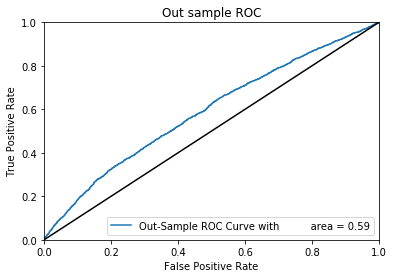

0.17328835 0.12840138474769391


In [10]:
prediction=model.predict([X_test_arr,X_test_time_pid,X_test_page,X_test_f2])
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
(fpr, tpr, thresholds) = roc_curve(y_test,prediction)
area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with \
         area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out sample ROC')
plt.legend(loc="lower right")
plt.show()

def get_KS(y_prob,y_true):
    fpr,tpr,threshold=roc_curve(y_true,y_prob)
    ks=(tpr-fpr)
    max_=np.argmax(ks)
    
    return threshold[max_],np.max(ks)
threshold,ks=get_KS(prediction,y_test)
print(threshold,ks)